# 05 - Full waveform inversion with Devito and Dask (distributed computing)

## Introduction

In this tutorial we show how [Devito](http://www.opesci.org/devito-public) and [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) are used with [Dask](https://dask.pydata.org/en/latest/#dask) to perform [full waveform inversion](https://www.slim.eos.ubc.ca/research/inversion) (FWI) on distributed memory parallel computers.

This tutorial uses the same synthetic datasets and model setup as the previous two tutorals, so check back if you get lost on parts of the code specific to Devito or SciPy.optimize. 

## What is Dask?

> [Dask](https://dask.pydata.org/en/latest/#dask) is a flexible parallel computing library for analytic computing.
>
> Dask is composed of two components:
>
> * Dynamic task scheduling optimized for computation...
> * “Big Data” collections like parallel arrays, dataframes, and lists that extend common interfaces like NumPy, Pandas, or Python iterators to larger-than-memory or distributed environments. These parallel collections run on top of the dynamic task schedulers.
>
> Dask emphasizes the following virtues:
> 
> * Familiar: Provides parallelized NumPy array and Pandas DataFrame objects
> * Flexible: Provides a task scheduling interface for more custom workloads and integration with other projects.
> * Native: Enables distributed computing in Pure Python with access to the PyData stack.
> * Fast: Operates with low overhead, low latency, and minimal serialization necessary for fast numerical algorithms
> * Scales up: Runs resiliently on clusters with 1000s of cores
> * Scales down: Trivial to set up and run on a laptop in a single process
> * Responsive: Designed with interactive computing in mind it provides rapid feedback and diagnostics to aid humans

**We are going to use it here to parallelise the computation of the functional and gradient as this is the vast bulk of the computational expense of FWI and it is trivially parallel over data shots.**

## Setting up (synthetic) data
In a real world scenario we work with collected seismic data; for the tutorial we know what the actual solution is and we are using the workers to also generate the synthetic data.

In [1]:
#NBVAL_IGNORE_OUTPUT

# Set up inversion parameters.
param = {'t0': 0.,
         'tn': 1000.,              # Simulation last 1 second (1000 ms)
         'f0': 0.010,              # Source peak frequency is 10Hz (0.010 kHz)
         'nshots': 5,              # Number of shots to create gradient from
         'm_bounds': (0.08, 0.25)} # Set the min and max slowness

import numpy as np

import scipy
from scipy import signal, optimize

from devito import Grid

from distributed import as_completed, Client, wait
import cloudpickle as pickle

from examples.seismic import Model, demo_model
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import RickerSource, Receiver

# Import convenience function for plotting results
from examples.seismic import plot_image

# Import acoustic solver, source and receiver modules.
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import PointSource, RickerSource, Receiver

def get_shape():
    ''' Number of grid point (nx, nz).
    '''
    shape = (101, 101)
    return shape

def get_spacing():
    ''' Grid spacing in m. The domain size is now 1km by 1km.
    '''
    spacing = (10., 10.)
    return spacing

def get_origin():
    ''' Need origin to define relative source and receiver locations.
    '''
    origin = (0., 0.)
    return origin

def get_nbpml():
    ''' Get nbpml thickness.
    '''
    return 40

def get_true_model():
    ''' Define the test phantom; in this case we are using
    a simple circle so we can easily see what is going on.
    '''
    return demo_model('circle-isotropic', vp=3.0, vp_background=2.5, 
                      origin=get_origin(), shape=get_shape(),
                      spacing=get_spacing(), nbpml=get_nbpml())

def get_initial_model():
    '''The initial guess for the subsurface model.
    '''
    return demo_model('circle-isotropic', vp=2.5, vp_background=2.5, 
                      origin=get_origin(), shape=get_shape(),
                      spacing=get_spacing(), nbpml=get_nbpml())

def wrap_model(x, astype=None):
    '''Wrap a flat array as a subsurface model.
    '''
    model = get_initial_model()
    if astype:
        model.m.data[:] = x.astype(astype).reshape(model.m.data.shape)
    else:
        model.m.data[:] = x.reshape(model.m.data.shape)
    return model

def get_current_model(param):
    """ Returns the current model. This is used by the
    worker to get the current model.
    """
    model = wrap_model(np.load(param['model']))
    return model

def dump_model(param, model):
    ''' Dump model to disk.
    '''
    np.save(param['model'], model.astype(np.float32))
    
def load_shot_data(shot_id, dt):
    ''' Load shot data from disk, resampling to the model time step.
    '''
    pkl = pickle.load(open("shot_%d.p"%shot_id, "rb"))
    pkl_grid = Grid(extent=pkl['grid_extent'],
                    shape=pkl['grid_shape'],
                    dimensions=pkl['grid_dimensions'])
    time = pkl['time']
    src = PointSource(name=pkl['src.name'], grid=pkl_grid,
                      npoint=pkl['src.coordinates'].shape[0],
                      time=time, data=pkl['src.data'],
                      coordinates=pkl['src.coordinates'])
    rec = PointSource(name=pkl['rec.name'], grid=pkl_grid,
                      time=time, data=pkl['rec.data'],
                      npoint=pkl['rec.coordinates'].shape[0])
    rec.coordinates.data[:] = pkl['rec.coordinates']
    
    return src.resample(dt), rec.resample(dt)

def dump_shot_data(shot_id, src, rec):
    ''' Dump shot data to disk.
    '''
    pickle.dump({'grid_extent':src.grid.extent,
                 'grid_shape':src.grid.shape,
                 'grid_dimensions':src.grid.dimensions,
                 'time':src.time(),
                 'src.name':src.name,
                 'src.data':np.array(src.data),
                 'src.coordinates':np.array(src.coordinates.data),
                 'rec.name':rec.name,
                 'rec.data':np.array(rec.data),
                 'rec.coordinates':np.array(rec.coordinates.data)},
                open('shot_%d.p'%shot_id, "wb"))
    
def generate_shotdata_i(param):
    """ Inversion crime alert! Here the worker is creating the
        'observed' data using the real model. For a real case
        the worker would be reading seismic data from disk.
    """
    true_model = get_true_model()
    shot_id = param['shot_id']
    
    # Time step from model grid spacing
    dt = true_model.critical_dt

    # Set up source data and geometry.
    nt = int(1 + (param['tn']-param['t0']) / dt)  # Discrete time axis length

    # Add padding
    tn = (nt-1)*dt
    
    time=np.linspace(param['t0'], tn, nt)
    src = RickerSource(name='src', grid=true_model.grid, f0=param['f0'], time=time)

    src.coordinates.data[0, :] = [30, param['shot_id']*1000./(param['nshots']-1)]
    
    # Number of receiver locations per shot.
    nreceivers = 101

    # Set up receiver data and geometry.
    rec = Receiver(name='rec', grid=true_model.grid, time=time, npoint=nreceivers)
    rec.coordinates.data[:, 1] = np.linspace(0, true_model.domain_size[0], num=nreceivers)
    rec.coordinates.data[:, 0] = 980. # 20m from the right end

    # Set up solver.
    solver = AcousticWaveSolver(true_model, src, rec, space_order=4)

    # Generate synthetic receiver data from true model.
    true_d, _, _ = solver.forward(src=src, m=true_model.m)

    dump_shot_data(shot_id, src, true_d)

def generate_shotdata(param):
    # Define work list
    work = [dict(param) for i in range(param['nshots'])]
    for i in  range(param['nshots']):
        work[i]['shot_id'] = i
        generate_shotdata_i(work[i])
        
    # Start dask cluster
    client = Client(processes=False)
    
    # Map worklist to cluster
    futures = client.map(generate_shotdata_i, work)

    # Wait for all futures
    wait(futures)
    
    # Shutdown cluster
    client.close()

In [2]:
#NBVAL_IGNORE_OUTPUT

generate_shotdata(param)

CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/b70b66698cfb3ce45d1677661589dd9334e2d3c4.c [1.02 s]
Section section_1<713,1> with OI=0.93 computed in 0.000 s [0.46 GFlops/s]
Section section_2<713,101> with OI=1.62 computed in 0.001 s [2.50 GFlops/s]
Section main<713,181,181> with OI=2.00 computed in 0.195 s [3.84 GFlops/s, 0.12 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/b70b66698cfb3ce45d1677661589dd9334e2d3c4.c [0.43 s]
Section section_1<713,1> with OI=0.93 computed in 0.000 s [0.48 GFlops/s]
Section section_2<713,101> with OI=1.62 computed in 0.001 s [2.49 GFlops/s]
Section main<713,181,181> with OI=2.00 computed in 0.200 s [3.74 GFlops/s, 0.12 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/b70b66698cfb3ce45d1677661589dd9334e2d3c4.c [0.44 s]
Section section_1<713,1> with OI=0.93 computed in 0.000 s [0.55 GFlops/s]
Section section_2<713,10

## Dask specifics

Previously we defined a function to calculate the individual contribution to the functional and gradient for each shot, which was then used in a loop over all shots. However, when using distributed frameworks such as Dask we instead think in terms of creating a worklist which gets *mapped* onto the worker pool. The sum reduction is also performed in parallel. For now however we assume that the scipy.optimize.minimize itself is running on the *master* process; this is a reasonable simplification because the computational cost of calculating (f, g) far exceeds the other compute costs.

Because we want to be able to use standard reduction operators such as sum on (f, g) we first define it as a type so that we can define the `__add__` (and `__rand__` method).

In [3]:
# Define a type to store the functional and gradient.
class fg_pair:
    def __init__(self, f, g):
        self.f = f
        self.g = g
    
    def __add__(self, other):
        f = self.f + other.f
        g = self.g + other.g
        
        return fg_pair(f, g)
    
    def __radd__(self, other):
        if other == 0:
            return self
        else:
            return self.__add__(other)

Next we define the functional and gradient operator for a single shot of data. This is the work that is going to be performed by the worker on a unit of data.

In [4]:
from devito import Function

# Create FWI gradient kernel for a single shot
def fwi_gradient_i(param):
    from devito import clear_cache

    # Need to clear the workers cache.
    clear_cache()

    # Load the current model and the shot data for this worker.
    # Note, unlike the serial example the model is not passed in
    # as an argument. Broadcasting large datasets is considered
    # a programming anti-pattern and at the time of writing it
    # it only worked relaiably with Dask master. Therefore, the
    # the model is communicated via a file.
    model0 = get_current_model(param)
    
    dt = model0.critical_dt

    src, rec = load_shot_data(param['shot_id'], dt)

    # Set up solver.
    solver = AcousticWaveSolver(model0, src, rec, space_order=4)

    # Compute simulated data and full forward wavefield u0
    d, u0, _ = solver.forward(src=src, m=model0.m, save=True)
        
    # Compute the data misfit (residual) and objective function
    residual = Receiver(name='rec', grid=model0.grid,
                        t0=rec.t0, dt=rec.dt, ntime=rec.data.shape[0],
                        coordinates=rec.coordinates.data)

    residual.data[:] = d.data[:] - rec.data[:]
    f = .5*np.linalg.norm(residual.data.flatten())**2
    
    # Compute gradient using the adjoint-state method. Note, this
    # backpropagates the data misfit through the model.
    grad = Function(name="grad", grid=model0.grid)
    solver.gradient(rec=residual, u=u0, m=model0.m, grad=grad)
    
    # Copying here to avoid a (probably overzealous) destructor deleting
    # the gradient before Dask has had a chance to communicate it.
    g = np.array(grad.data[:])
    
    # return the objective functional and gradient.
    return fg_pair(f, g)

Define the global functional-gradient operator. This does the following:
* Creates the Dask cluster
* Maps the worklist (shots) to the workers so that the invidual contributions to (f, g) are computed.
* Sum individual contributions to (f, g) and returns the result.

In [5]:
def fwi_gradient(model, param):
    # Dump a copy of the current model for the workers
    # to pick up when they are ready.
    param['model'] = "model_0.npy"
    dump_model(param, model)

    # Define work list
    work = [dict(param) for i in range(param['nshots'])]
    for i in  range(param['nshots']):
        work[i]['shot_id'] = i
        
    # Start dask cluster
    client = Client(processes=False)
    
    # Distribute worklist to workers.
    fgi = client.map(fwi_gradient_i, work, retries=1)
    
    # Perform reduction.
    fg = client.submit(sum, fgi).result()
        
    # Shutdown cluster
    client.close()
    
    # L-BFGS in scipy expects a flat array in 64-bit floats.
    return fg.f, fg.g.flatten().astype(np.float64)

## FWI with L-BFGS-B
Equipped with a function to calculate the functional and gradient, we are finally ready to define the optimization function.

In [6]:
from scipy import optimize

# Define bounding box constraints on the solution.
def apply_box_constraint(m):
    # Maximum possible 'realistic' velocity is 3.5 km/sec
    # Minimum possible 'realistic' velocity is 2 km/sec
    return np.clip(m, 1/3.5**2, 1/2**2)

# Many optimization methods in scipy.optimize.minimize accept a callback
# function that can operate on the solution after every iteration. Here
# we use this to apply box constraints and to monitor the true relative
# solution error.
relative_error = []
def fwi_callbacks(x):
    # Apply boundary constraint
    x.data[:] = apply_box_constraint(x)
    
    # Calculate true relative error
    true_x = get_true_model().m.data.flatten()
    relative_error.append(np.linalg.norm((x-true_x)/true_x))

def fwi(model, param, ftol=0.1, maxiter=20):
    result = optimize.minimize(fwi_gradient,
                               model.m.data.flatten().astype(np.float64),
                               args=(param, ), method='L-BFGS-B', jac=True,
                               callback=fwi_callbacks,
                               options={'ftol':ftol,
                                        'maxiter':maxiter,
                                        'disp':True})

    return result

We now apply our FWI function and have a look at the result.

In [7]:
#NBVAL_IGNORE_OUTPUT

model0 = get_initial_model()

# Baby steps
result = fwi(model0, param)

# Print out results of optimizer.
print(result)

CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [0.66 s]
Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.21 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.27 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.229 s [2.72 GFlops/s, 0.09 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [0.62 s]
Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.37 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.81 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.209 s [2.98 GFlops/s, 0.09 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [0.62 s]
Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.32 GFlops/s]
Section section_2<595,10

Section section_1<595,101> with OI=0.93 computed in 0.001 s [3.10 GFlops/s]
Section main<595,181,181> with OI=1.39 computed in 0.398 s [1.91 GFlops/s, 0.05 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [0.51 s]
Section section_1<595,101> with OI=0.93 computed in 0.001 s [2.39 GFlops/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [0.63 s]
Section main<595,181,181> with OI=1.39 computed in 0.427 s [1.78 GFlops/s, 0.05 GPts/s]
Section section_1<595,101> with OI=0.93 computed in 0.001 s [2.94 GFlops/s]
Section main<595,181,181> with OI=1.39 computed in 0.399 s [1.90 GFlops/s, 0.05 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [0.56 s]
Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.19 GFlops/s]
Section 

Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.21 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.39 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.236 s [2.64 GFlops/s, 0.08 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [0.62 s]
Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.21 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.38 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.241 s [2.58 GFlops/s, 0.08 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [0.84 s]
Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.31 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.66 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.208 s [3.01 GFlops/s, 0.09 GPts/s]
Cu

CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [0.57 s]
Section section_1<595,101> with OI=0.93 computed in 0.001 s [3.02 GFlops/s]
Section main<595,181,181> with OI=1.39 computed in 0.398 s [1.91 GFlops/s, 0.05 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [0.45 s]
Section section_1<595,101> with OI=0.93 computed in 0.001 s [2.91 GFlops/s]
Section main<595,181,181> with OI=1.39 computed in 0.394 s [1.93 GFlops/s, 0.05 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [0.53 s]
Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.27 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.54 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.203 s [3.07 GFlops/s, 0.10 GPts/s]
CustomCo

Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.21 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.54 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.224 s [2.79 GFlops/s, 0.09 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [0.70 s]
Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.23 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.70 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.226 s [2.75 GFlops/s, 0.09 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [0.69 s]
Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.26 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.58 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.218 s [2.86 GFlops/s, 0.09 GPts/s]
Cu

Section main<595,181,181> with OI=1.39 computed in 0.629 s [1.21 GFlops/s, 0.03 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [1.14 s]
Section section_1<595,101> with OI=0.93 computed in 0.002 s [2.01 GFlops/s]
Section main<595,181,181> with OI=1.39 computed in 0.541 s [1.40 GFlops/s, 0.04 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [0.42 s]
Section section_1<595,1> with OI=0.93 computed in 0.001 s [0.05 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.002 s [1.33 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.395 s [1.58 GFlops/s, 0.05 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [0.41 s]
Section section_1<595,101> with OI=0.93 computed in 0.001 s [3.23 GFlops/s]
Section 

CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [1.16 s]
Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.32 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.57 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.213 s [2.93 GFlops/s, 0.09 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [1.43 s]
Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.09 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.002 s [1.46 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.348 s [1.79 GFlops/s, 0.06 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [0.64 s]
Section section_1<595,101> with OI=0.93 computed in 0.001 s [2.71 GFlops/s]
Section main<595,181,1

Section section_1<595,101> with OI=0.93 computed in 0.001 s [2.77 GFlops/s]
Section main<595,181,181> with OI=1.39 computed in 0.410 s [1.86 GFlops/s, 0.05 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [0.42 s]
Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.26 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.79 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.204 s [3.06 GFlops/s, 0.10 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [0.39 s]
Section section_1<595,101> with OI=0.93 computed in 0.001 s [3.23 GFlops/s]
Section main<595,181,181> with OI=1.39 computed in 0.381 s [2.00 GFlops/s, 0.05 GPts/s]
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc local=inproc://192.168.0.15/61024/86 remote=inproc://192.168.0.15/61024/81>
Cust

Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.80 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.207 s [3.01 GFlops/s, 0.09 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [0.89 s]
Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.29 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.64 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.211 s [2.95 GFlops/s, 0.09 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [0.64 s]
Section section_1<595,101> with OI=0.93 computed in 0.001 s [2.63 GFlops/s]
Section main<595,181,181> with OI=1.39 computed in 0.413 s [1.84 GFlops/s, 0.05 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [0.71 s]
CustomCo

Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.24 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.76 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.203 s [3.07 GFlops/s, 0.10 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [0.41 s]
Section section_1<595,101> with OI=0.93 computed in 0.001 s [3.03 GFlops/s]
Section main<595,181,181> with OI=1.39 computed in 0.398 s [1.91 GFlops/s, 0.05 GPts/s]
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc local=inproc://192.168.0.15/61024/107 remote=inproc://192.168.0.15/61024/102>
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/f9802da74807d254328fd7038b56c4848b77cd40.c [0.74 s]
Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.29 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.35 GFlops/s]
Section main<595

Section section_1<595,1> with OI=0.93 computed in 0.000 s [0.21 GFlops/s]
Section section_2<595,101> with OI=1.62 computed in 0.001 s [2.32 GFlops/s]
Section main<595,181,181> with OI=2.00 computed in 0.247 s [2.53 GFlops/s, 0.08 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [0.62 s]
Section section_1<595,101> with OI=0.93 computed in 0.001 s [2.58 GFlops/s]
Section main<595,181,181> with OI=1.39 computed in 0.409 s [1.86 GFlops/s, 0.05 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [1.48 s]
Section section_1<595,101> with OI=0.93 computed in 0.002 s [1.79 GFlops/s]
Section main<595,181,181> with OI=1.39 computed in 0.618 s [1.23 GFlops/s, 0.03 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [0.70 s]
Section 

Section main<595,181,181> with OI=2.00 computed in 0.357 s [1.75 GFlops/s, 0.05 GPts/s]
CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-sxaru09q/8b3a3abd95038a5295c5057146e08dafae096e5f.c [0.66 s]
Section section_1<595,101> with OI=0.93 computed in 0.001 s [3.02 GFlops/s]
Section main<595,181,181> with OI=1.39 computed in 0.406 s [1.87 GFlops/s, 0.05 GPts/s]


      fun: 17.07605840657891
 hess_inv: <32761x32761 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.50646031e-12, 2.04465923e-11, 5.14643050e-11, ...,
       3.55223073e-11, 1.39667488e-11, 3.05933902e-12])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 15
   status: 0
  success: True
        x: array([0.16, 0.16, 0.16, ..., 0.16, 0.16, 0.16])


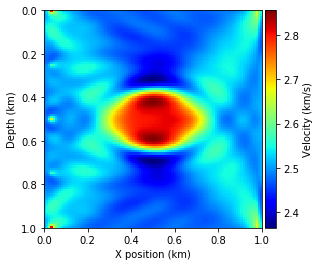

In [8]:
#NBVAL_SKIP

# Show what the update does to the model
from examples.seismic import plot_image, plot_velocity

model0.m.data[:] = result.x.astype(np.float32).reshape(model0.m.data.shape)
model0.vp = np.sqrt(1. / model0.m.data[40:-40, 40:-40])
plot_velocity(model0)

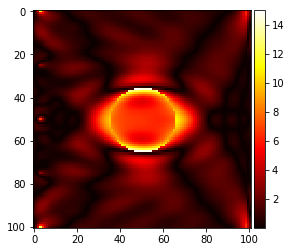

In [9]:
#NBVAL_SKIP

# Plot percentage error
plot_image(100*np.abs(model0.vp-get_true_model().vp.data)/get_true_model().vp.data, vmax=15, cmap="hot")

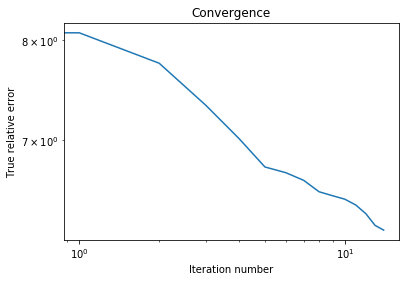

In [10]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(relative_error)
plt.xlabel('Iteration number')
plt.ylabel('True relative error')
plt.title('Convergence')
plt.show()

<sup>This notebook is part of the tutorial "Optimised Symbolic Finite Difference Computation with Devito" presented at the Intel® HPC Developer Conference 2017.</sup>